In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split

from utils import *

### Load and explore data

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

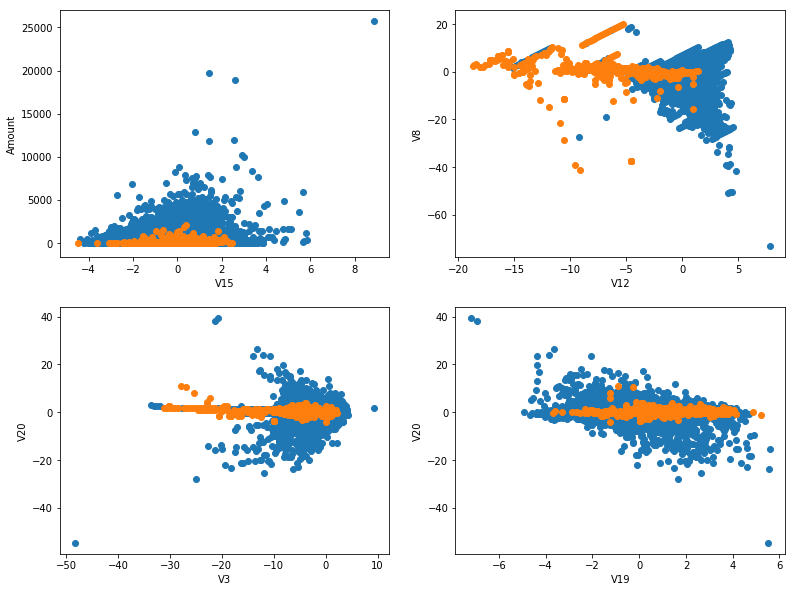

In [4]:
col_names = list(data.columns)[1:-1] ## TODO what is this?
tile_random_features(col_names, data)

### Prep data

In [5]:
train, test = train_test_split(data, test_size=0.2)

print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

% of fraud cases in original, train, and test sets:
0.00172748563062
0.00173802365643
0.00168533408237


In [6]:
# Split into features / class labels
train_x, train_y = [df.as_matrix() for df in split_class(train)]
test_x, test_y = [df.as_matrix() for df in split_class(test)]

## Performance Metrics

Note that a dumb majority class classifier has incredible accuracy!

In [7]:
from sklearn.metrics import accuracy_score
bs_pred = np.zeros(test_y.shape)
accuracy_score(test_y, bs_pred)

0.9983146659176293

That's hard to beat!

However what we really care about is not primarily accurancy. We want high recall so that we can find as much fraud ass possible while not creating _too_ many false positives

In [8]:
from sklearn.metrics import recall_score
print "Recall:"
recall_score(test_y, bs_pred)

Recall:


0.0

Recall is quite bad, making this a very poor classifier for finding fraud

Thus we will try to find a sampling methods that has good recall and better-than-horrible precision (or alternatively, high accurancy).

## Implement sampling methods on training data

According to we background we did to test different classifiers we are going to test our sampling methods on 3 classifiers: Logistic Regression, QDA, and Decision Trees (CART)

In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [10]:
# best results from hyper parameter search
logit_params = {'penalty': 'l2', 'C': 0.001}

### Over sampling

In [11]:
from imblearn.over_sampling import RandomOverSampler
train_x_res, train_y_res = RandomOverSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227449), (1, 227449)]


In [12]:
run_compare_sampling(RandomOverSampler, LogisticRegression, train_x_res, train_y_res, test_x, test_y, **logit_params)
run_compare_sampling(RandomOverSampler, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(RandomOverSampler, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: RandomOverSampler
Class counts:
[(0, 227449), (1, 227449)]

LogisticRegression
Geometric mean:	0.939060779471
Recall: 	0.90625
Precision:	0.053736874614
Accuracy:	0.972946876865
Confusion mat: 
[[55334  1532]
 [    9    87]]

LogisticRegression
Geometric mean:	0.939060779471
Recall: 	0.90625
Precision:	0.053736874614
Accuracy:	0.972946876865
Confusion mat: 
[[55334  1532]
 [    9    87]]

Sampler: RandomOverSampler
Class counts:
[(0, 227449), (1, 227449)]

QuadraticDiscriminantAnalysis
Geometric mean:	0.940137805955
Recall: 	0.90625
Precision:	0.0583109919571
Accuracy:	0.975176433412
Confusion mat: 
[[55461  1405]
 [    9    87]]

QuadraticDiscriminantAnalysis
Geometric mean:	0.940679800073
Recall: 	0.916666666667
Precision:	0.0427184466019
Accuracy:	0.965239984551
Confusion mat: 
[[54894  1972]
 [    8    88]]

Sampler: RandomOverSampler
Class counts:
[(0, 227449), (1, 227449)]

DecisionTreeClassifier
Geometric mean:	0.907011938754
Recall: 	0.822916666667
Precision:	0.8229166

### Under sampling

In [13]:
from imblearn.under_sampling import RandomUnderSampler
train_x_res, train_y_res = RandomUnderSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 396), (1, 396)]


In [14]:
run_compare_sampling(RandomUnderSampler, LogisticRegression, train_x_res, train_y_res, test_x, test_y,**logit_params)
run_compare_sampling(RandomUnderSampler, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(RandomUnderSampler, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: RandomUnderSampler
Class counts:
[(0, 396), (1, 396)]

LogisticRegression
Geometric mean:	0.937201712434
Recall: 	0.895833333333
Precision:	0.0719063545151
Accuracy:	0.980337769039
Confusion mat: 
[[55756  1110]
 [   10    86]]

LogisticRegression
Geometric mean:	0.937201712434
Recall: 	0.895833333333
Precision:	0.0719063545151
Accuracy:	0.980337769039
Confusion mat: 
[[55756  1110]
 [   10    86]]

Sampler: RandomUnderSampler
Class counts:
[(0, 396), (1, 396)]

QuadraticDiscriminantAnalysis
Geometric mean:	0.940137805955
Recall: 	0.90625
Precision:	0.0583109919571
Accuracy:	0.975176433412
Confusion mat: 
[[55461  1405]
 [    9    87]]

QuadraticDiscriminantAnalysis
Geometric mean:	0.931228387312
Recall: 	0.927083333333
Precision:	0.0236513420144
Accuracy:	0.935377971279
Confusion mat: 
[[53192  3674]
 [    7    89]]

Sampler: RandomUnderSampler
Class counts:
[(0, 396), (1, 396)]

DecisionTreeClassifier
Geometric mean:	0.895425671184
Recall: 	0.802083333333
Precision:	0.785714

### SMOTE/ADASYN oversampling

In [15]:
from imblearn.over_sampling import SMOTE, ADASYN
train_x_res, train_y_res = SMOTE(kind='regular').fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227449), (1, 227449)]


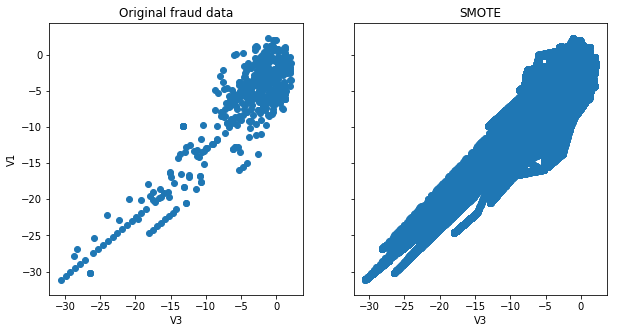

In [16]:
minorty = train_x_res[train_y_res == 1]
col_names = fradulent.columns
cols = (1,3)

fig, axarr = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax_orig = axarr[0]
ax_smote = axarr[1]

ax_orig.scatter(fradulent[col_names[cols[0]]],fradulent[col_names[cols[1]]])
ax_orig.set_title('Original fraud data')
ax_orig.set_ylabel(col_names[cols[0]])
ax_orig.set_xlabel(col_names[cols[1]])

ax_smote.scatter(minorty[:,cols[0]], minorty[:,cols[1]])
ax_smote.set_title('SMOTE')
ax_smote.set_xlabel(col_names[cols[1]])

plt.show()

In [17]:
run_compare_sampling(SMOTE, LogisticRegression, train_x_res, train_y_res, test_x, test_y,**logit_params)
run_compare_sampling(SMOTE, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(SMOTE, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: SMOTE
Class counts:
[(0, 227449), (1, 227449)]

LogisticRegression
Geometric mean:	0.944205800079
Recall: 	0.90625
Precision:	0.0860534124629
Accuracy:	0.983620659387
Confusion mat: 
[[55942   924]
 [    9    87]]

LogisticRegression
Geometric mean:	0.944205800079
Recall: 	0.90625
Precision:	0.0860534124629
Accuracy:	0.983620659387
Confusion mat: 
[[55942   924]
 [    9    87]]

Sampler: SMOTE
Class counts:
[(0, 227449), (1, 227449)]

QuadraticDiscriminantAnalysis
Geometric mean:	0.940137805955
Recall: 	0.90625
Precision:	0.0583109919571
Accuracy:	0.975176433412
Confusion mat: 
[[55461  1405]
 [    9    87]]

QuadraticDiscriminantAnalysis
Geometric mean:	0.939578245488
Recall: 	0.90625
Precision:	0.0558408215661
Accuracy:	0.97401776623
Confusion mat: 
[[55395  1471]
 [    9    87]]

Sampler: SMOTE
Class counts:
[(0, 227449), (1, 227449)]

DecisionTreeClassifier
Geometric mean:	0.895433547178
Recall: 	0.802083333333
Precision:	0.79381443299
Accuracy:	0.999315333029
Confusion ma

In [18]:
run_compare_sampling(ADASYN, LogisticRegression, train_x_res, train_y_res, test_x, test_y, **logit_params)
run_compare_sampling(ADASYN, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(ADASYN, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: ADASYN
Class counts:
[(0, 227449), (1, 227449)]

LogisticRegression
Geometric mean:	0.944205800079
Recall: 	0.90625
Precision:	0.0860534124629
Accuracy:	0.983620659387
Confusion mat: 
[[55942   924]
 [    9    87]]

LogisticRegression
Geometric mean:	0.944205800079
Recall: 	0.90625
Precision:	0.0860534124629
Accuracy:	0.983620659387
Confusion mat: 
[[55942   924]
 [    9    87]]

Sampler: ADASYN
Class counts:
[(0, 227449), (1, 227472)]

QuadraticDiscriminantAnalysis
Geometric mean:	0.940137805955
Recall: 	0.90625
Precision:	0.0583109919571
Accuracy:	0.975176433412
Confusion mat: 
[[55461  1405]
 [    9    87]]

QuadraticDiscriminantAnalysis
Geometric mean:	0.939144849309
Recall: 	0.916666666667
Precision:	0.0393032603841
Accuracy:	0.96209753871
Confusion mat: 
[[54715  2151]
 [    8    88]]

Sampler: ADASYN
Class counts:
[(0, 227449), (1, 227472)]

DecisionTreeClassifier
Geometric mean:	0.895449298958
Recall: 	0.802083333333
Precision:	0.810526315789
Accuracy:	0.999350444156
C